In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [74]:
model = torchvision.models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(512, 2).to(device)

/home/exouser/.conda/envs/me592/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.conda/envs/me592/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
data = pd.read_csv("./Take_1805_0401/robot_log.csv", delimiter=";")
data.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.050054,0,0.000000,99.67006,85.58908,0.003138,55.36451,0.000004
1,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.249989,0,0.000000,99.67096,85.59039,0.037067,55.40277,-0.000032
2,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.449343,0,0.013232,99.67258,85.59274,0.095625,55.48328,-0.000129
3,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.648888,0,0.070054,99.67466,85.59576,0.171125,55.51194,-0.000208
4,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.799269,0,0.079751,99.68039,85.60406,0.362626,55.42231,0.000153


In [76]:
data = data[["Path", "SteerAngle", "Throttle"]]
data.head()

,Path,SteerAngle,Throttle
0,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.050054
1,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.249989
2,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.449343
3,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.648888
4,C:\Users\laksh\OneDrive\Desktop\IMG\IMG\roboca...,0.0,0.799269


In [77]:
data["Path"] = data["Path"].apply(lambda x: x.replace("C:\\Users\\laksh\\OneDrive\\Desktop", "./Take_1805_0401"))
data["Path"] = data["Path"].apply(lambda x: x.replace("\\", "/"))
data["Path"] = data["Path"].apply(lambda x: x.replace("IMG/IMG", "IMG"))
data.head()

,Path,SteerAngle,Throttle
0,./Take_1805_0401/IMG/robocam_2024_04_01_18_03_...,0.0,0.050054
1,./Take_1805_0401/IMG/robocam_2024_04_01_18_03_...,0.0,0.249989
2,./Take_1805_0401/IMG/robocam_2024_04_01_18_03_...,0.0,0.449343
3,./Take_1805_0401/IMG/robocam_2024_04_01_18_03_...,0.0,0.648888
4,./Take_1805_0401/IMG/robocam_2024_04_01_18_03_...,0.0,0.799269


In [86]:
class RobotDataset(Dataset):
    def __init__(self, data, device="cuda"):
        super(RobotDataset, self).__init__()
        arrangement = np.arange(len(data))
        np.random.shuffle(arrangement)
        data = data.iloc[arrangement]
        self.data = data
        self.device = device
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row["Path"])
        img = torchvision.transforms.functional.to_tensor(img).to(self.device)
        return img, torch.tensor([row["SteerAngle"], row["Throttle"]], dtype=torch.float32).to(self.device)

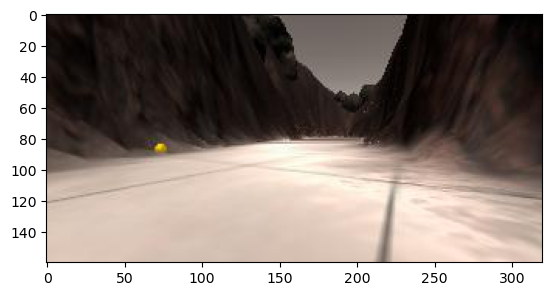

tensor([0., 0.], device='cuda:0')


In [87]:
dataset = RobotDataset(data)
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.show()
print(label)

In [80]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [81]:
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))
print("Total dataset size: ", len(dataset))

Train dataset size:  632
Test dataset size:  158
Total dataset size:  790


In [82]:
epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
TrainingLosses = []
TestLosses = []
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss / len(train_loader)}")
    TrainingLosses.append(train_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for i, (img, label) in enumerate(test_loader):
            output = model(img)
            loss = criterion(output, label)
            test_loss += loss.item()
    this_epoch_time = time.time() - start_time
    TestLosses.append(test_loss / len(test_loader))
    print(f"Epoch: {epoch+1}, Test Loss: {test_loss / len(test_loader)}")
    print(f"Epoch: {epoch+1}, Time Alloted: {this_epoch_time}")
    print("------------------"*5)

Epoch: 1, Train Loss: 6.20050835609436
Epoch: 1, Test Loss: 6.267533779144287
Epoch: 1, Time Alloted: 1.2518806457519531
------------------------------------------------------------------------------------------
Epoch: 2, Train Loss: 2.608045923709869
Epoch: 2, Test Loss: 6.34922981262207
Epoch: 2, Time Alloted: 1.3966357707977295
------------------------------------------------------------------------------------------
Epoch: 3, Train Loss: 0.9864696204662323
Epoch: 3, Test Loss: 3.8414204915364585
Epoch: 3, Time Alloted: 1.2482292652130127
------------------------------------------------------------------------------------------
Epoch: 4, Train Loss: 0.6885690450668335
Epoch: 4, Test Loss: 3.5649463335673013
Epoch: 4, Time Alloted: 1.2579009532928467
------------------------------------------------------------------------------------------
Epoch: 5, Train Loss: 0.6065348416566849
Epoch: 5, Test Loss: 2.8415674368540444
Epoch: 5, Time Alloted: 1.2942886352539062
----------------------

Text(0, 0.5, 'Loss')

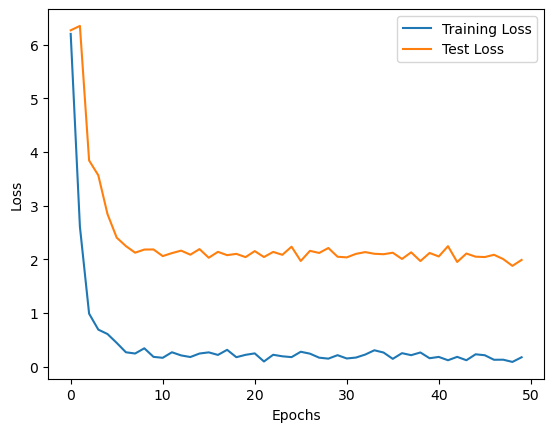

In [83]:
plt.plot(TrainingLosses, label="Training Loss")
plt.plot(TestLosses, label="Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")